# Image to Text Generation using BLIP-2

## Introduction 

Training a model focused on a single modality is already resource-intensive and costly, but the expenses for comprehensive vision-and-language pre-training are becoming excessively high. Addressing this issue, BLIP-2 introduces a novel approach for visual-language pre-training that can utilize any combination of pre-trained vision encoders and language models without the need for full architecture pre-training. This method allows for top-tier performance across various visual-language tasks while greatly cutting down on the number of parameters that need training and the overall pre-training expenses.

In this lesson, we will just focus on getting setup to work with BLIP-2 model for image to text generation. To see how BLIP-2 model work, visit this [link](https://huggingface.co/blog/blip-2).

## Installing necessary libraries

In [1]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-yzt22nf1
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-yzt22nf1
  Resolved https://github.com/huggingface/transformers.git to commit 25b0f2033ba23e354ef2f665764248fcbb3f49ba
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for huggingface-hub<1.0,>=0.19.3 from https://files.pythonhosted.org/packages/05/09/1945ca6ba3ad8ad6e2872ba682ce8d68c5e63c8e55458ed8ab4885709f1d/huggingface_hub-0.19.4-py3-none-any.whl.metadata
INFO: pip is looking at multiple versions of tokenizers to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for tokenizers<0.19,>=0.14 from https://files.pythonhosted.org/packages/eb/3d/eee5f3c572a3f4db2ebabf5bd4f284f356078a5b5d27e6

## Import Necessary Libraries

In [4]:
# Deep Learning Libraries
from transformers import pipeline as image_to_text_pipeline
import torch

# Garbage Clearance
import os
import gc

# To save the model
import pickle

# For loading image
import requests
from PIL import Image

import re

## Loading, Saving and Reloading the Model

In [3]:
# To manages to optimize GPU Memory
def flush():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

In [1]:
!pwd

/kaggle/working


In [9]:
model_path = "/kaggle/working/Image-To-Text/models"
os.makedirs(model_path, exist_ok=True)

In [8]:
blip_2_model_path = os.path.join(model_path, 'blip-2-opt-2.7b.pkl')
if not os.path.exists(blip_2_model_path):
    ## Loading the model
    pipe = image_to_text_pipeline(model="Salesforce/blip2-opt-2.7b", device=0, torch_dtype=torch.bfloat16)
    ## Saving the Model
    pickle.dump(pipe, open(blip_2_model_path, "wb"))
    del pipe
    flush()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
## Reloading the Model
blip_2_model_path = os.path.join(model_path, 'blip-2-opt-2.7b.pkl')
with open(blip_2_model_path, 'rb') as f:
    pipe = pickle.load(f)
flush()

Note that we are pickling the model as in pickle format it loads the model much faster when we do inferencing. 

## Inference with Model


### Image Captioning

Lets see how well BLIP-2 performs captioning of image.

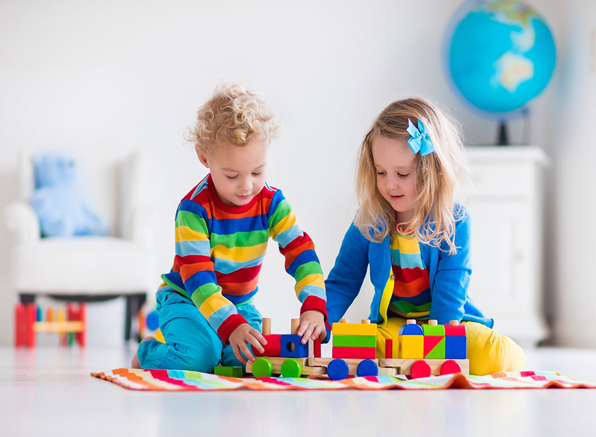

In [38]:
image_url = 'https://parenting.firstcry.ae/memories/getMyMemoryImages/2018/05/349318436-H.jpg'
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')  
display(image.resize((596, 437)))

We will enter all our inputs in the dictionary (which can be then replicated as input json body when model used for production purpose). 

In [24]:
image_url = 'https://parenting.firstcry.ae/memories/getMyMemoryImages/2018/05/349318436-H.jpg'

params = {
    "prompt": None,
    "images": Image.open(requests.get(image_url, stream=True).raw).convert('RGB'),
    "max_new_tokens": 400,
}

In [25]:
output_text = pipe(**params)

In [26]:
output_text

[{'generated_text': 'two children playing with wooden blocks in a room\n'}]

We also can enter one or more image links for image captioning. 

In [39]:
image_urls = "https://parenting.firstcry.ae/memories/getMyMemoryImages/2018/05/349318436-H.jpg,https://www.thoughtco.com/thmb/o2xaDCaMW93CkSN0kVm53Rj5-Iw=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/BarackObama-799035cd446c443fb392110c01768ed0.jpg"

# Note that more complex logic required if the image links are complex
image_links = image_urls.split(",") 

# Filter out the links based on image extensions
images = [Image.open(requests.get(url, stream=True).raw).convert('RGB') for url in image_links]

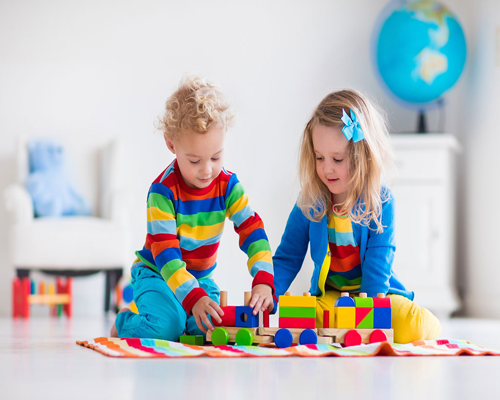

In [54]:
display(images[0].resize((500, 400)))

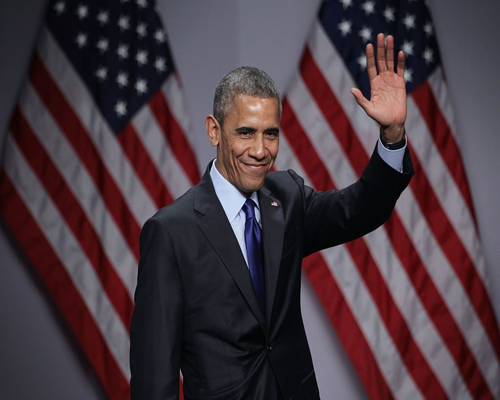

In [55]:
display(images[1].resize((500, 400)))

In [47]:
params = {
    "prompt": None,
    "images": images,
    "max_new_tokens": 400,
}

In [48]:
output_text = pipe(**params)
output_text

[[{'generated_text': 'two children playing with wooden blocks in a room\n'}],
 [{'generated_text': 'president obama waves to the crowd at the end of his speech\n'}]]

### Prompted Image Captioning


We can enhance image captioning by adding a textual prompt that the model will follow based on the given image.

In [60]:
params = {
    "prompt": "This is a photo of",
    "images": images[1],
    "max_new_tokens": 400,
}

In [61]:
output_text = pipe(**params)
output_text

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


[{'generated_text': ' president barack obama waving to the crowd at the end of his speech at the convention center in chicago on july 28, 2012\n'}]

### Visual Question Answering

In visual question answering, the prompt must adhere to a specific structure: "Question: {} Answer:".

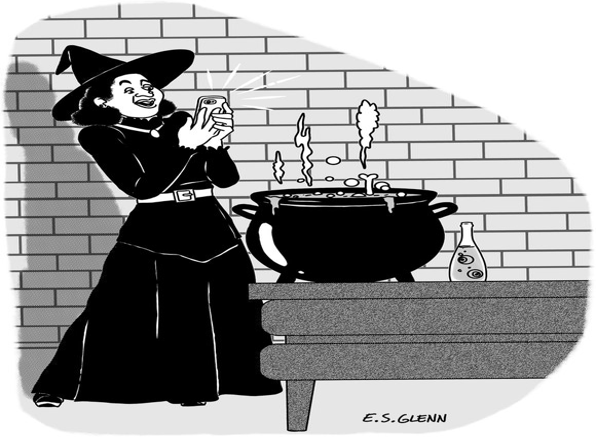

In [71]:
image_url = 'https://media.newyorker.com/cartoons/65285719435b28d4ebf6b5a0/master/w_580,c_limit/231023_a27249_871.jpg'
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')  
display(image.resize((596, 437)))

In [72]:
params = {
    "prompt": "Question: What is the woman doing? Answer:",
    "images": image,
    "max_new_tokens": 400,
}

In [73]:
output_text = pipe(**params)
output_text

[{'generated_text': " She's making a potion\n"}]

## Conclusion

- Throughout this tutorial, we've explored three distinct applications facilitated by the BLIP-2 model.
- The model's capabilities include visual prompting, which can be further extended to ChatGPT-style conversational prompts. This offers an interesting opportunity for experimentation, which you're encouraged to try as a practical exercise.
- BLIP-2 demonstrated remarkable proficiency in interpreting and explaining the content of images. This efficiency makes it particularly advantageous in scenarios where there are limited examples available for training or analysis.

## Reference

- Zero-shot image-to-text generation with BLIP-2 - https://huggingface.co/blog/blip-2
- Model Card: https://huggingface.co/Salesforce/blip2-opt-2.7b
- Pipeline Documentation: https://huggingface.co/docs/transformers/main/en/model_doc/blip-2#transformers.Blip2ForConditionalGeneration.forward.example